In [1]:
import os
import re
import sys
import cv2
import PIL
import glob
import math
import datetime
import openslide
import numpy as np
import pandas as pd
from PIL import Image
import multiprocessing
import matplotlib.pyplot as plt
from openslide import OpenSlideError
from PIL import Image, ImageDraw, ImageFont
#from functions_1 import *

In [2]:
data_path = "./Pathology_data_raw_file/"
total_files = os.listdir(data_path)
total_files

['test-001.svs', '._test-001.svs']

In [3]:
# Arguments and variable values
SCALE_FACTOR = 32
patch_size=1024

In [4]:
def filter_rgb_to_grayscale(np_img, output_type="uint8"):
  grayscale = np.dot(np_img[..., :3], [0.2125, 0.7154, 0.0721])
  if output_type != "float":
    grayscale = grayscale.astype("uint8")
  return grayscale
# creating tiles directory
if not os.path.isdir("./tiles/"):
  os.mkdir("./tiles/")

test-001.svs
46000 32914 1437 1028 2 <PIL.Image.Image image mode=RGB size=2875x2057 at 0x7F57EF6BDAC8> <PIL.Image.Image image mode=RGB size=1437x1028 at 0x7F57EF6BD9E8>


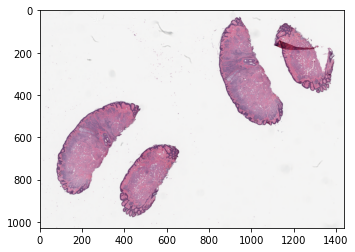

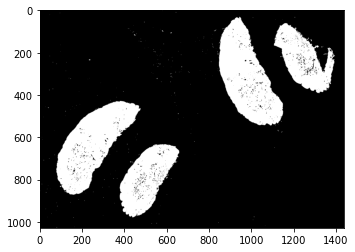

273193
1477236
Total tissue is 18.0%
Total Non-tissue is 82.0%
44 32
._test-001.svs


UnidentifiedImageError: cannot identify image file './Pathology_data_raw_file//._test-001.svs'

In [5]:
for file in total_files:
    if file.endswith ('.svs'):
        print(file)
        slide = openslide.open_slide(data_path+'/'+file) # "openslide.open_slide" is a function for reading .svs files
        large_w, large_h = slide.dimensions
        new_w = math.floor(large_w / SCALE_FACTOR)
        new_h = math.floor(large_h / SCALE_FACTOR)
        level = slide.get_best_level_for_downsample(SCALE_FACTOR) # WSIs are pyramidal structure so level is magnification level
        whole_slide_image = slide.read_region((0, 0), level, slide.level_dimensions[level])
        whole_slide_image = whole_slide_image.convert("RGB")
        img = whole_slide_image.resize((new_w, new_h), PIL.Image.BILINEAR)
        print(large_w, large_h, new_w, new_h, level, whole_slide_image, img)
        plt.imshow(img)
        plt.show()
        file_name = 'X_'+ str(new_w) + '_Y_'+ str(new_h) + '.png'
        # Save file into .pngs (X= 1437, Y= 1028)
        img.save(file_name)
        np_img = np.asanyarray(img)
        r2bgray = filter_rgb_to_grayscale(np_img, output_type="uint8")
        (thresh, im_bw) = cv2.threshold(r2bgray, 0,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        convert_bin = np.invert(im_bw)
        plt.imshow(convert_bin, cmap='gray')
        plt.show()
        df = pd.DataFrame(convert_bin)
        total_pixels = df.size
        non_zeropixels = np.count_nonzero(df)
        print(non_zeropixels)
        print(total_pixels)
        Total_tissue_percentage = np.round((non_zeropixels/total_pixels)*100)
        Total_non_tissue_pixels =(total_pixels - non_zeropixels)
        Total_non_tissue_percentage =  np.round((Total_non_tissue_pixels/total_pixels)*100)
        print(f'Total tissue is {Total_tissue_percentage}%')
        print(f'Total Non-tissue is {Total_non_tissue_percentage}%')
        # defining patch size 
        
        # getting dimensions of WSI and upper bounds for n_across and n_down
        #width,height=wsi.dimensions
        #large_w, large_h = slide.dimensions
        #print(large_w, large_h)
        n_across=large_w//patch_size
        n_down=large_h//patch_size
        print(n_across, n_down)

        # initializing parameters
        n_patches=0
        j=1
        flag=0
        i=1
        # iterating over WSI and extracting 256 X 256 tiles
        for y in range(n_down):
            for x in range(n_across):  
              # getting tile using read_region() function
              patch=slide.read_region((x*patch_size,y*patch_size),0,(patch_size,patch_size))

              # converting to RGB
              patch = patch.convert("RGB")

              # defining target directory to store tiles
              target_dir="wsi_%d"%(i)+"_tile_%d.png"%(j)

              # output path
              out_path=os.path.join("./tiles",target_dir)
              j+=1
              # Saving patch in output path
              patch.save(out_path)
        i+=1
        
    